# Mescoscopic Community Portfolio

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict

from portfolio import Portfolio

dir_data = 'data/'
dir_fig = 'fig/'

C:\Users\BillyLjm\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm_joblib\__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Investment Universe

We are focused on portfolio optimisation, and not stock picking.\
Thus for simplicty, our investment universe will be the current S&P 500 constituents with daily price data from 2000 to 2024.

The code below downloads the relevant data from the internet.

In [2]:
# Get current constituents of S&P 500
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# Get price data from yfinance
prices = yf.download(sp500['Symbol'].tolist(), auto_adjust=False,
                     start='2000-01-01', end='2024-12-31')['Adj Close']

# Filter only stocks that have daily price data throughout time period
prices = prices.dropna(axis=1)
prices.to_csv('data/prices.csv')

sp500 = sp500[sp500['Symbol'].isin(prices.columns)]
sp500 = sp500.sort_values(by='Symbol').reset_index(drop=True)
sp500.to_csv('data/sp500.csv', index=False)

sp500

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2000-01-01 -> 2024-12-31)')


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",2000-06-05,1090872,1999
1,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ACGL,Arch Capital Group,Financials,Property & Casualty Insurance,"Hamilton, Bermuda",2022-11-01,947484,1995
4,ADBE,Adobe Inc.,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982
...,...,...,...,...,...,...,...,...
344,WY,Weyerhaeuser,Real Estate,Timber REITs,"Seattle, Washington",1979-10-01,106535,1900
345,XEL,Xcel Energy,Utilities,Multi-Utilities,"Minneapolis, Minnesota",1957-03-04,72903,1909
346,XOM,ExxonMobil,Energy,Integrated Oil & Gas,"Irving, Texas",1957-03-04,34088,1999
347,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997


## Create Porfolio

With the data downloaded, we create the Portoflio class which does all the claculations and optimisations.

In [3]:
# create sector mapping
sectors = pd.read_csv(dir_data + 'sp500.csv')
sectors = dict(zip(sectors['Symbol'], sectors['GICS Sector']))

# read price data
price_data =  pd.read_csv(dir_data + 'prices.csv', index_col=0)
price_data.index = pd.to_datetime(price_data.index)

# create portfolio class
portfolio = Portfolio(price_data, sectors)

## Mesocopic Correlation

We applied the Laloux corrections to the correlation matrix to yield the mesoscopic correlation matrix

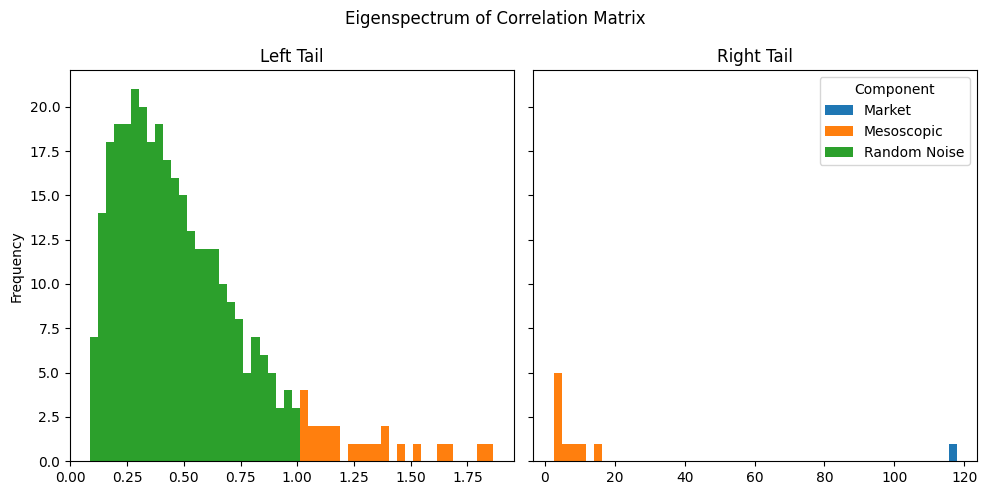

In [4]:
# plot eigenspectrum deomposition
eigvals, _, components, lambda_max, lambda_1 = portfolio.mesoscopic_decompose()
df = pd.DataFrame({'component': components, 'eigval': eigvals})
df = df.pivot(columns='component', values='eigval')

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
# left tail
df[df.sum(axis=1) < lambda_max+1].plot.hist(
    bins=50, density=False, stacked=True, legend=False, ax=axs[0])
axs[0].set_title('Left Tail')
# right tail
df.iloc[-10:].plot.hist(bins=50, density=False, stacked=True, ax=axs[1])
axs[1].legend(title='Component')
axs[1].set_title('Right Tail')
# overall
plt.suptitle('Eigenspectrum of Correlation Matrix')
plt.tight_layout()
plt.savefig(dir_fig + 'meso_corr_spectrum.png')
plt.show()

  0%|                                                                                         | 0/6036 [00:00<?, ?it/s]

  0%|          | 0/6036 [00:00<?, ?it/s]

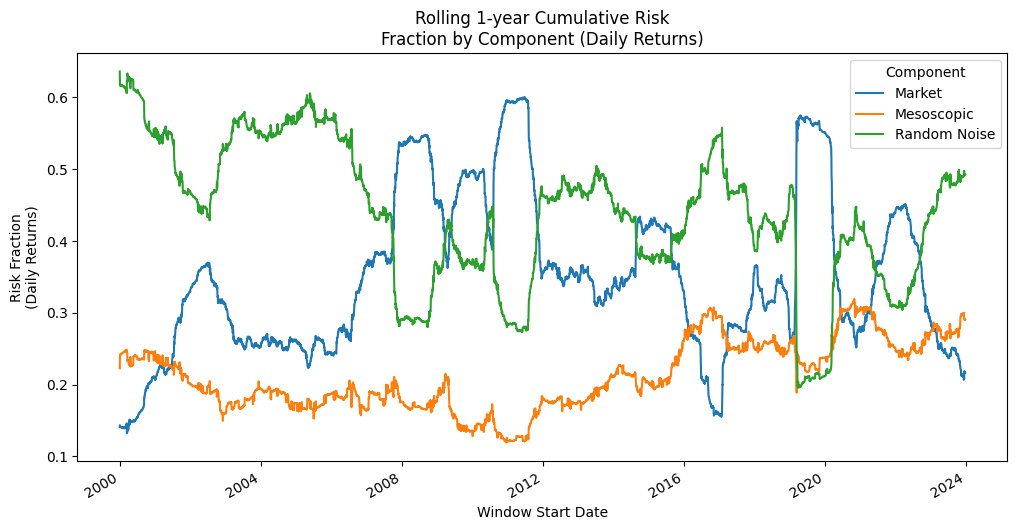

In [5]:
# calculate cumulative risks
risks = portfolio.rolling_cumulative_risk(window=252, step=1)
risks_frac = risks.div(risks.sum(axis=1), axis=0)

# plot
risks_frac.plot(figsize=(12,6))
plt.title('Rolling 1-year Cumulative Risk\nFraction by Component (Daily Returns)')
plt.xlabel('Window Start Date')
plt.ylabel('Risk Fraction\n(Daily Returns)')
plt.legend(title='Component')
plt.savefig(dir_fig + 'meso_corr_rolling.png')
plt.show()

## Community Detection

Applying the various algorithms to cluster the stocks together based on the mescoscopic correlation matrix

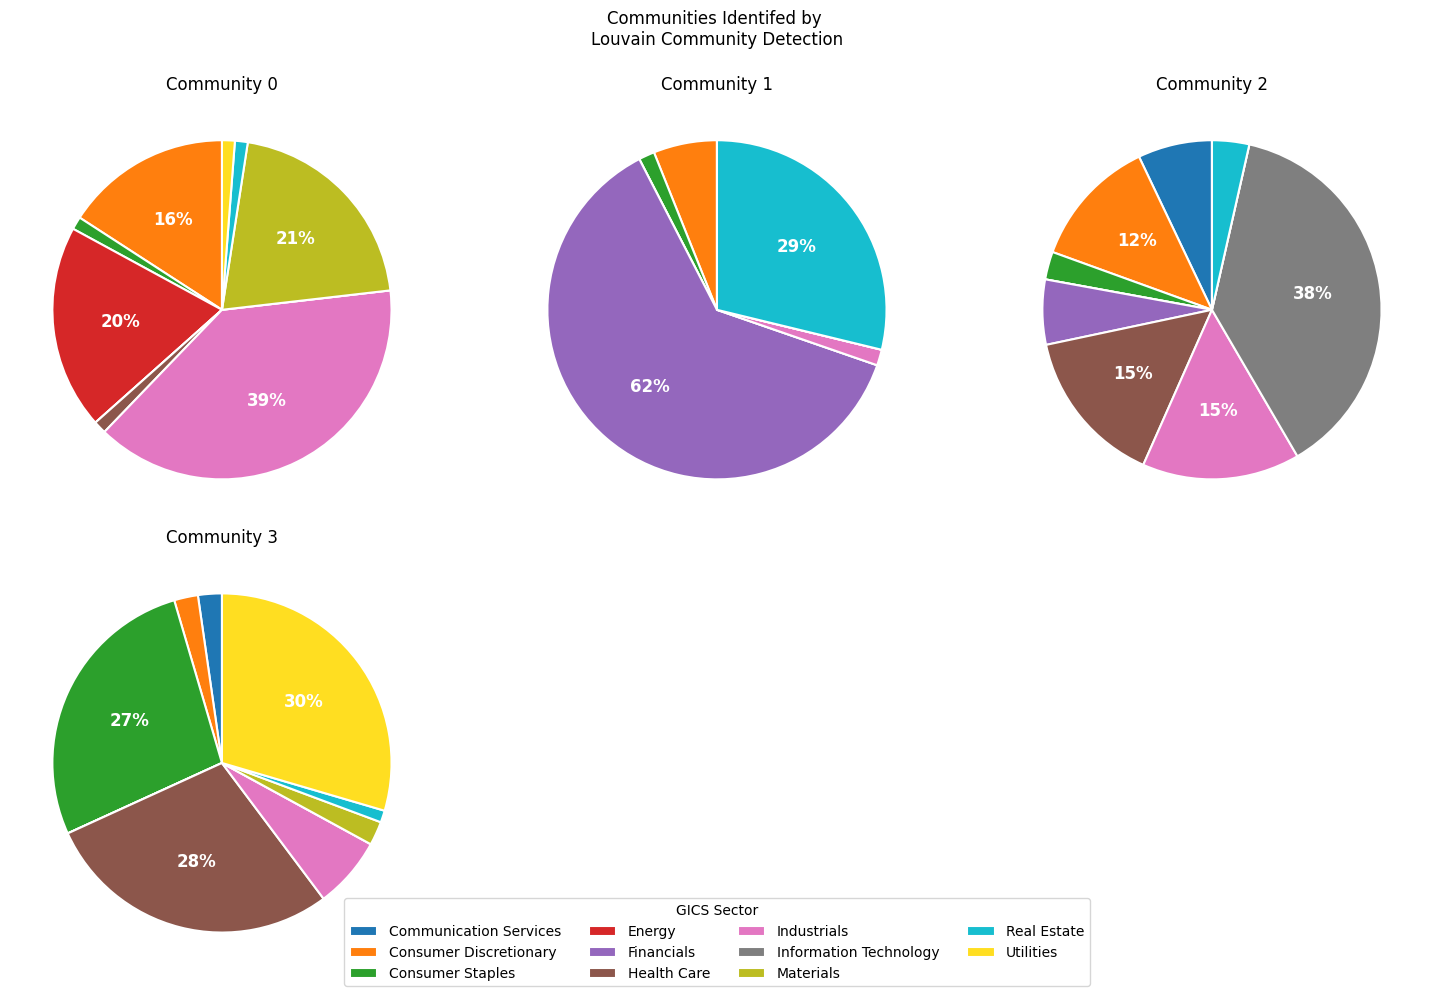

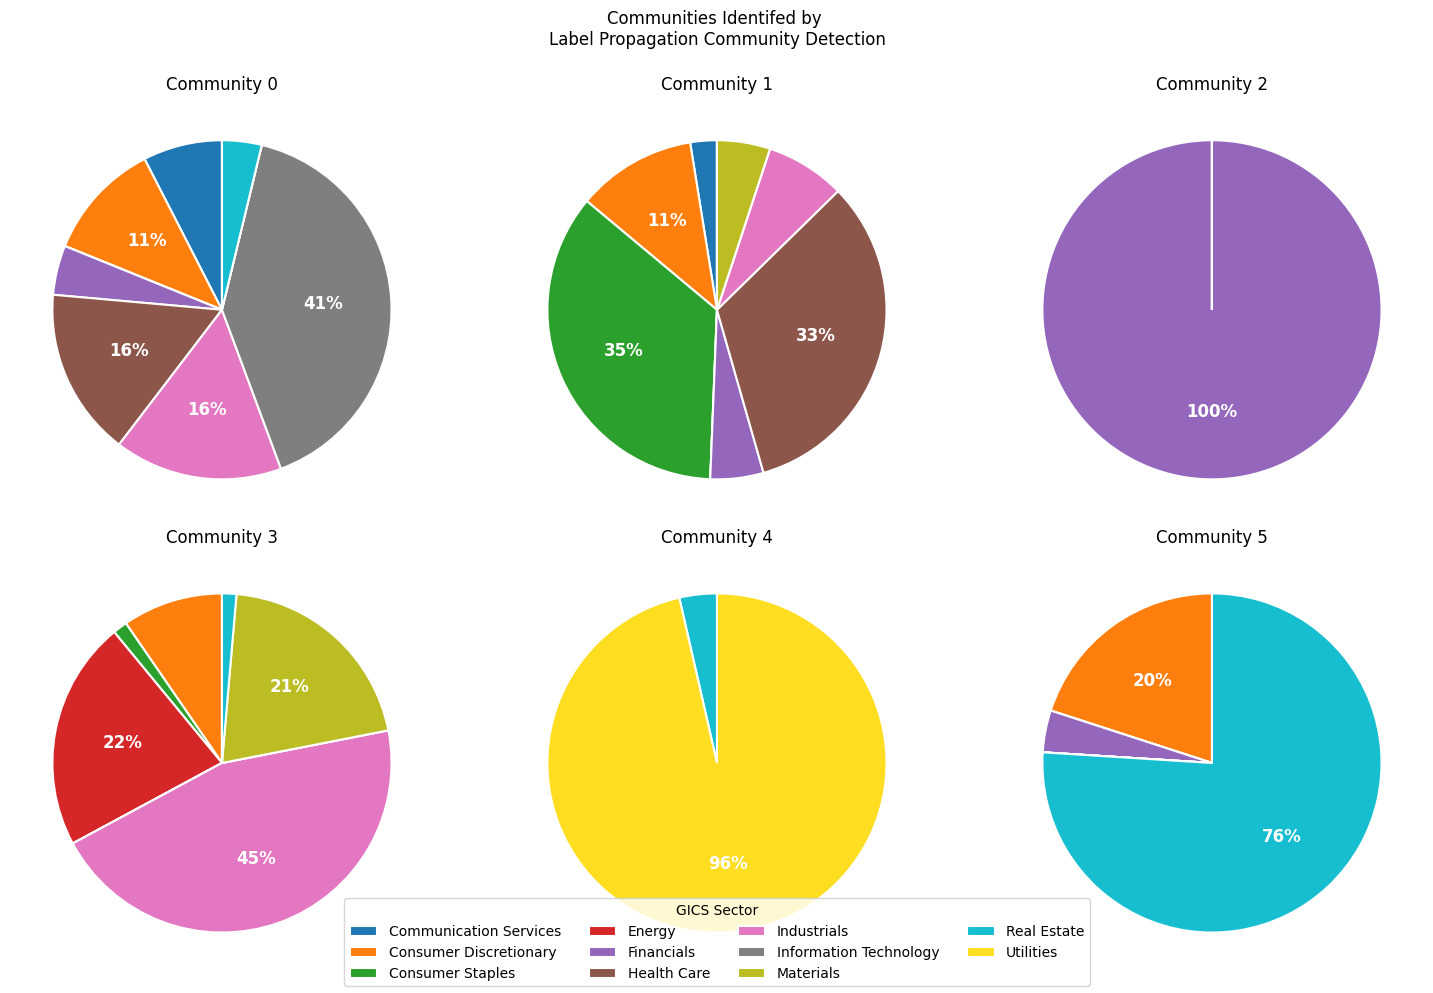

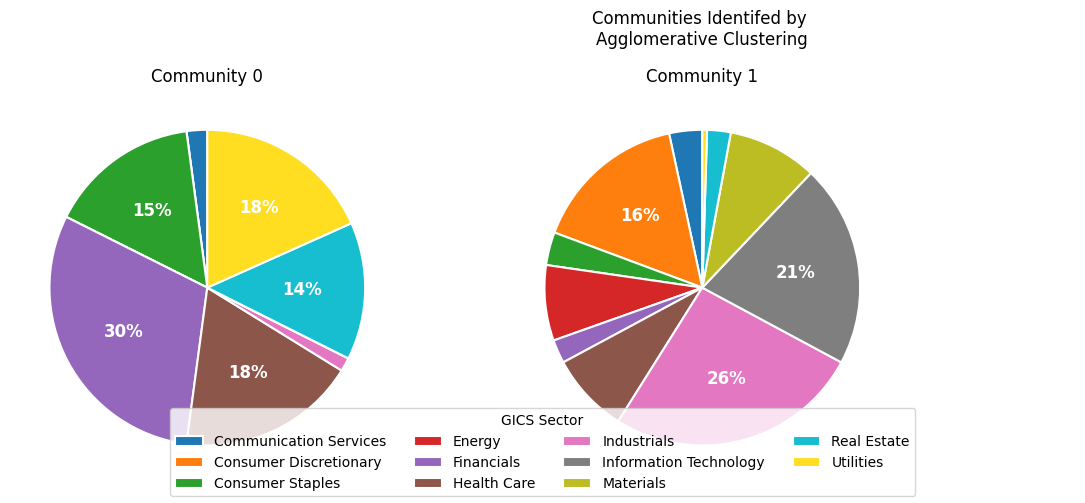

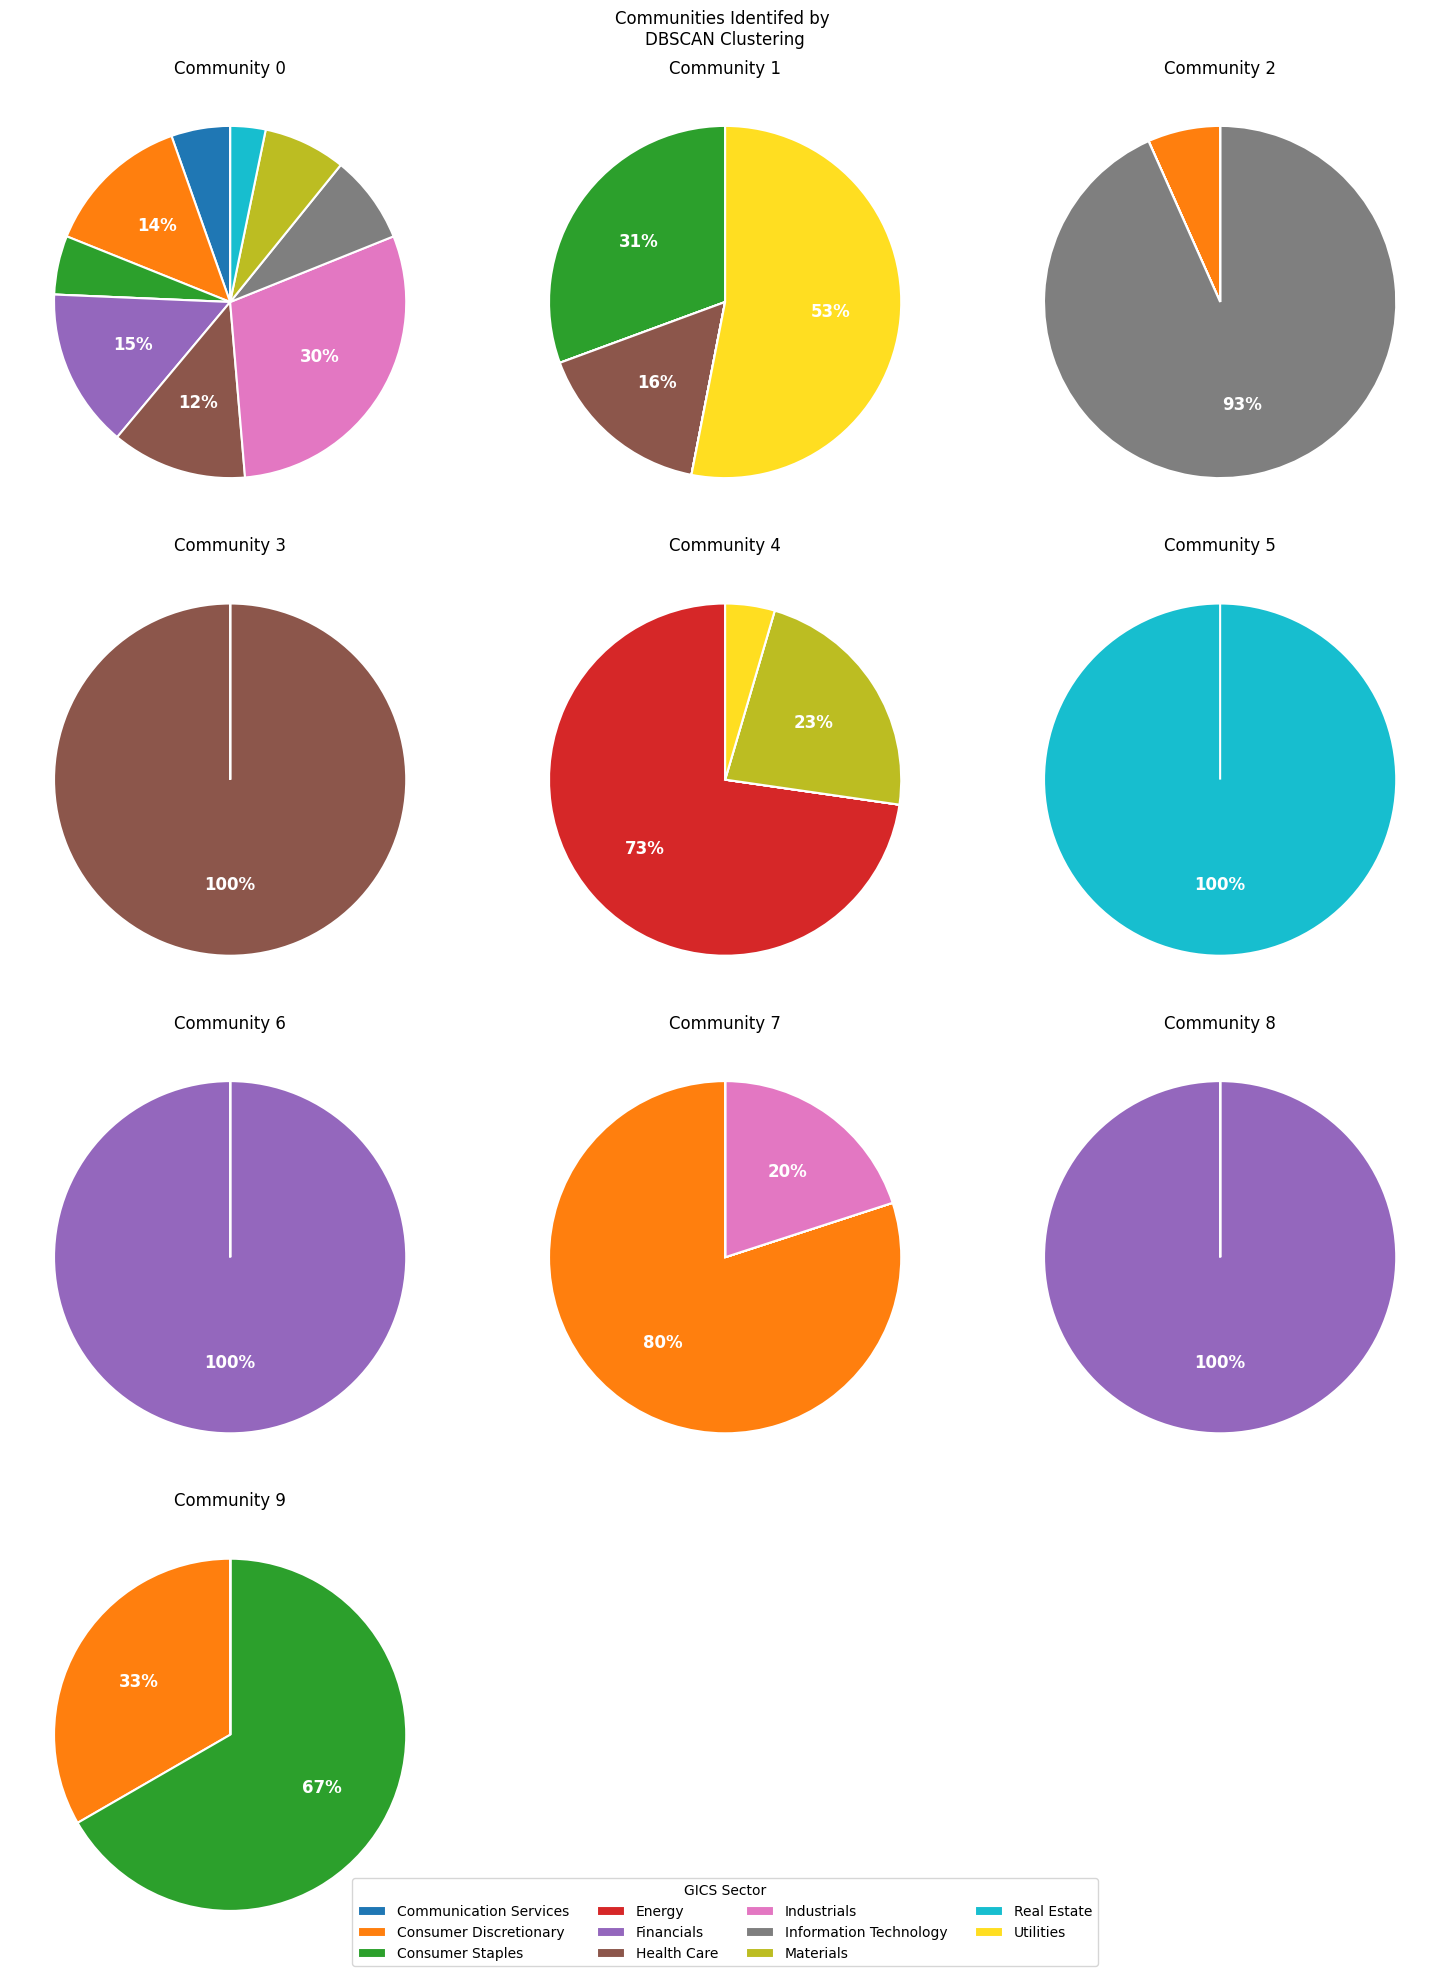

In [6]:
# find communities & plot GICS sector composition
for algo in ('Louvain', 'Label Propagation', 'Agglomerative', 'DBSCAN'):
    # discover community
    portfolio.community_detection(algo)
    df = pd.DataFrame({'community': portfolio.communities, 'sector': portfolio.sectors})
    df = pd.pivot_table(df, index='sector', columns='community', aggfunc='size').fillna(0)
    df.columns = df.columns.astype(int)
    
    # create subplots
    ncols = 3
    nrows = int(np.ceil(df.shape[1] / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, nrows*5))
    axs = axs.flatten()
    for j in range(df.shape[1] , len(axs)): fig.delaxes(axs[j])
    
    # plot pies charts
    for i, col in enumerate(df.columns):
        wedges, texts, autotexts = axs[i].pie(
            df[col], labels=None, startangle=90,
            autopct=lambda x: f'{x:.0f}%' if x >= 10 else '',
            colors=plt.cm.tab10.colors + ((1, 0.87, 0.13),),
            wedgeprops=dict(edgecolor='white', linewidth=1.5),
            textprops=dict(color='white', fontsize=12, fontweight='bold'),
        )
        axs[i].set_title(f'Community {col}')

    # figure clean-up
    if algo in ('Louvain', 'Label Propagation'):
        algo_full = algo + ' Community Detection'
    else:
        algo_full = algo + ' Clustering'
    fig.suptitle(f'Communities Identifed by \n{algo_full}\n')
    fig.legend(df.index, title='GICS Sector', loc='lower center', ncol=4)
    plt.tight_layout()
    plt.savefig(dir_fig + f'communities_{algo}.png')
    plt.show()

## Back-Testing

We optimise the weights between communities to yield the global-minimum-variance (GMV) portfolios, and keep equal weights within portfolios.  
These portfolios are then tested using an anchored walk-forward method, with a 1-year testing period, and a 3-year burn-in period

In [8]:
ret_data = price_data.pct_change()

# determine test start dates
period_test = pd.DateOffset(years=1)
period_burn = pd.DateOffset(years=3)
test_dates = pd.date_range(price_data.index.min() + period_burn, 
                           price_data.index.max() - period_test,
                           freq=pd.DateOffset(years=1))

# anchored walk-forward
returns = defaultdict(list)
reliability = defaultdict(list)
ncomm = defaultdict(list)
for algo in ('Louvain', 'Label Propagation', 'Agglomerative', 'DBSCAN', 'Sector', 'Equal-Weight', 'None'):
    pbar = tqdm(test_dates)
    pbar.set_description(algo)
    for test_date in pbar:
        # train portfolio optimisation
        portfolio = Portfolio(price_data[:test_date], sectors, algo=algo)
        # calculate returns in test period
        ret_test = ret_data[test_date:test_date + period_test]
        wts = ret_test.columns.map(portfolio.weights)
        ret_test = ret_test @ wts
        returns[algo].append(ret_test)
        # calculate reliability (via stdev in train dataset)
        ret_train = ret_data[:test_date ]
        wts = ret_train.columns.map(portfolio.weights)
        ret_train = ret_train @ wts
        reliability[algo].append(np.abs(np.std(ret_test)/np.std(ret_train) - 1))
        # remember the number of communities
        ncomm[algo].append(len(set(portfolio.communities.values())))
    returns[algo] = pd.concat(returns[algo]) # concat pandas time-series

returns = pd.DataFrame(returns)
reliability = pd.DataFrame(reliability)
ncomm = pd.DataFrame(ncomm)
returns.head()

None: 100%|████████████████████████████████████████████████████████████████████████████| 21/21 [00:44<00:00,  2.10s/it]


,Louvain,Label Propagation,Agglomerative,DBSCAN,Sector,Equal-Weight,None
Date,,,,,,,
2003-01-03,0.001145,-0.000624,-0.003422,-0.007407,-0.002531,-0.003346,-0.003112
2003-01-06,0.013623,0.019759,0.019624,0.020206,0.018707,0.019264,0.018515
2003-01-07,-0.011454,-0.012484,-0.007961,-0.007145,-0.009130,-0.008418,-0.009520
2003-01-08,-0.010211,-0.007531,-0.012491,-0.012665,-0.011294,-0.011911,-0.011121
2003-01-09,0.009993,0.012501,0.018325,0.015719,0.016541,0.017640,0.015583


In [9]:
# calculate aggregate metrics
summary = {}
summary['Sharpe Ratio'] = returns.mean() / returns.std() * np.sqrt(252)
summary['Mean Reliability'] = reliability.mean()
summary['Median Reliability'] = reliability.median()
summary['Mean Num Communities'] = ncomm.mean()
summary['Median Num Communities'] = ncomm.median()
summary = pd.DataFrame(summary)
summary.to_csv(dir_fig + 'sumamry.csv')
summary

,Sharpe Ratio,Mean Reliability,Median Reliability,Mean Num Communities,Median Num Communities
Louvain,0.805399,0.430134,0.323575,4.380952,4.0
Label Propagation,0.768600,0.448024,0.328851,6.142857,6.0
Agglomerative,0.779912,0.448033,0.384693,2.000000,2.0
DBSCAN,0.726555,0.449438,0.385930,10.476190,11.0
Sector,0.833947,0.414291,0.335409,11.000000,11.0
Equal-Weight,0.852736,0.410944,0.356951,1.000000,1.0
None,0.814471,0.422611,0.347190,349.000000,349.0


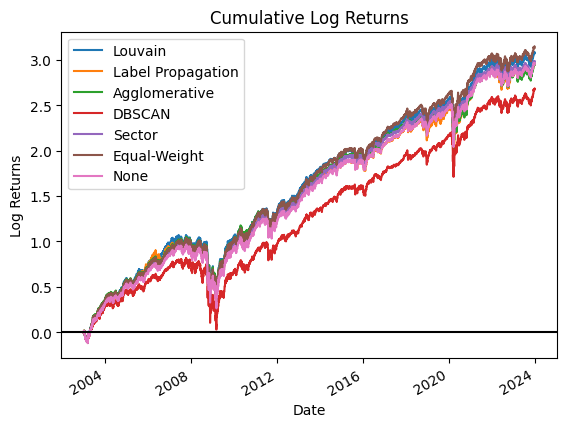

In [10]:
# plot returns
cumlogret = np.log((1 + returns).cumprod()) 
cumlogret.plot()
plt.axhline(0, color='k')
plt.title('Cumulative Log Returns')
plt.ylabel('Log Returns')
plt.savefig(dir_fig + 'cum_returns.png')
plt.show()